<a href="https://colab.research.google.com/github/callaghanmt-training/ou-fine-training-2025-11/blob/main/fine_tuning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Exploring base and instruction-tuned models

We will be using Google's Gemma 2 (2B parameter variant) models.  These are gated models so first head over to the [Gemma 2 2B model page](https://huggingface.co/google/gemma-2-2b), log into your Huggingface account and accept the licence terms.

You will also need your previously created **Access Token** so keep that somewhere handy.

Before you start, change the runtime type (from the **Runtime** menu above to a **T4** TPU.

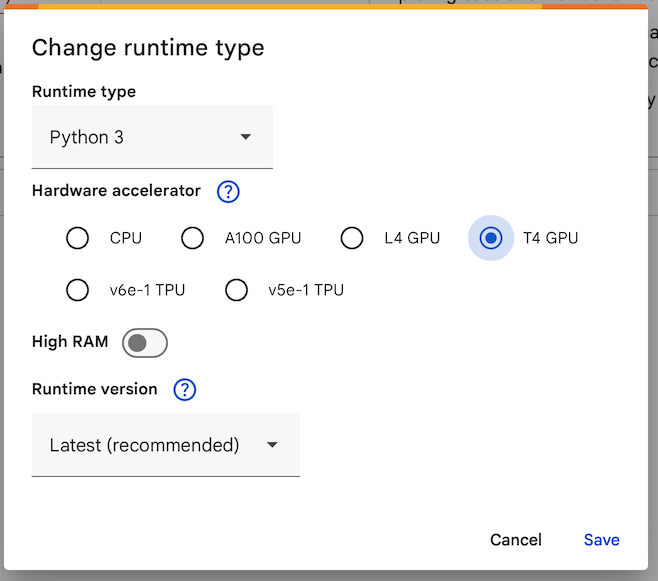

and click the **[Connect]** button to the top-right of this cell.

### Installation
First, we need to install the necessary libraries. We are using `accelerate` to handle hardware optimisation and `bitsandbytes` in case we want to load models in lower precision (though 2B fits in standard FP16 on Colab).

In [ ]:
# Install necessary libraries
!pip install -q -U transformers accelerate bitsandbytes

# Hugging Face Login
To access Gemma, we must authenticate.  The easiest option is to add your access token to a key called `HF_TOKEN` in the **Secrets** tab in the left menu.

Alternatively, either set an environment variable or complete your token in the cell below, uncomment and execute.

In [ ]:
from huggingface_hub import login
# You can paste your token directly here, or use the Colab 'Secrets' tab (recommended) as HF_TOKEN
# login(token="YOUR_HF_TOKEN_HERE")

# Interactive login
# login()

### Imports and Setup
We set up our device (GPU) to ensure the models run quickly.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
import gc # Garbage collection for memory management

# Set seed for reproducibility in a workshop setting
set_seed(42)

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

In [ ]:
# and it's always useful to check we really do have a GPU
!nvidia-smi

## Section 1: The Base Model
A "Base" model (Pre-trained model) is trained on massive amounts of raw text data to predict the next token. It is an autocomplete engine. It doesn't inherently know how to answer questions or follow instructions; it simply tries to continue the text pattern it sees.

### 1.1 Loading the Base Model
We will load `google/gemma-2-2b` (this step takes about 3 minutes).

In [ ]:
model_id_base = "google/gemma-2-2b"

tokenizer_base = AutoTokenizer.from_pretrained(model_id_base)
model_base = AutoModelForCausalLM.from_pretrained(
    model_id_base,
    device_map="auto",
    torch_dtype=torch.float16
)

print("Base model loaded.")

### 1.2 Prompting the Base Model
Let's give the base model an instruction. Watch how it behaves. It often continues the prompt as if it were part of a list or a document, rather than answering it.

In [ ]:
# The Prompt
prompt = "Write a polite email to my boss asking for a day off."

# Tokenise
inputs = tokenizer_base(prompt, return_tensors="pt").to(device)

# Generate
outputs = model_base.generate(
    **inputs,
    max_new_tokens=100,
    do_sample=True,
    temperature=0.7
)

# Decode
output_text = tokenizer_base.decode(outputs[0], skip_special_tokens=True)

print("-" * 20)
print(f"PROMPT: {prompt}")
print("-" * 20)
print(f"BASE MODEL OUTPUT:\n{output_text}")
print("-" * 20)

### Commentary:

**Observe the output**: Did the model write the email? Or did it perhaps generate something else?  Try running the same prompt a few times to see what happens.

**Why?** The base model saw the input as a text pattern to complete, not a command to obey.

### 1.3 Cleaning Up Memory
Since we are on Colab, we should clear the VRAM before loading the next model to avoid Out-Of-Memory errors.

In [ ]:
# Delete model and empty cache
del model_base
del tokenizer_base
gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")

## Section 2: The Instruction Tuned (IT) Model
An "Instruction Tuned" model starts as a Base model but undergoes further training (SFT - Supervised Fine-Tuning). It is trained on datasets of [Instruction, Response] pairs. It learns that when it sees a user prompt, it should provide a helpful answer.

### 2.1 Loading the IT Model
We will load `google/gemma-2-2b-it` - this cell takes about 3 minutes to load

In [ ]:
model_id_it = "google/gemma-2-2b-it"

tokenizer_it = AutoTokenizer.from_pretrained(model_id_it)
model_it = AutoModelForCausalLM.from_pretrained(
    model_id_it,
    device_map="auto",
    torch_dtype=torch.float16
)

print("Instruction Tuned model loaded.")

### 2.2 Prompting the IT Model
We use the exact same prompt. However, IT models expect a specific Chat Template (formatting that defines which part is the User and which is the Model). Hugging Face handles this via `apply_chat_template`.

In [ ]:
prompt = "Write a polite email to my boss asking for a day off."

# Format the prompt using the model's chat template
messages = [
    {"role": "user", "content": prompt},
]

# Apply chat template (adds special tokens like <start_of_turn>user)
input_ids = tokenizer_it.apply_chat_template(
    messages,
    return_tensors="pt",
    add_generation_prompt=True
).to(device)

# Generate
outputs = model_it.generate(
    input_ids,
    max_new_tokens=200,
    do_sample=True,
    temperature=0.7
)

# Decode (we slice the output to remove the input prompt from the result)
output_text = tokenizer_it.decode(outputs[0][input_ids.shape[-1]:], skip_special_tokens=True)

print("-" * 20)
print(f"PROMPT: {prompt}")
print("-" * 20)
print(f"INSTRUCTION TUNED OUTPUT:\n{output_text}")
print("-" * 20)

### Commentary:

**Observe the output**: The model should now generate the actual email body.

**Takeaway**: This is the goal of the workshop. We want to take a small model and fine-tune it so it behaves like the IT model but for our specific domain.

### Summary of differences:

| Feature |	Base Model | Instruction Tuned (IT) Model |
|---------|------------|------------------------------|
|**Training Data**|Raw internet text (Wikipedia, Code, Books)|Raw text + Instruction/Response pairs|
|**Goal**|	Predict next token|Follow user intent|
|**Behaviour**|Autocomplete / Rambling|Chat / Q&A|
|**Prompting**|Requires careful "few-shot" prompting|Standard chat formatting|